In [46]:
from utils import get_common_backbone_atoms, generate_df
from Bio import PDB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:

def get_rmsd(path_og, path_m):
    parser = PDB.PDBParser()
    structure_og = parser.get_structure("original", path_og)
    structure_m = parser.get_structure("mutation", path_m)
    atoms_og, atoms_m = get_common_backbone_atoms(structure_og, structure_m)
    superimposer = PDB.Superimposer()
    superimposer.set_atoms(atoms_og, atoms_m)
    superimposer.apply(structure_m.get_atoms())
    
    return superimposer.rms


df_paths = pd.read_csv('../datasets/df_with_scores.csv')


In [16]:
df_paths

,Protein change allele 1,Protein change allele 2,structure_allele1,structure_allele2,pdb_file_allele1,pdb_file_allele2,patient,sex,birth,bmi,...,KOOSsport,KOOS_QOL,HAQ_hapVAS,HAQ_haqDI,RMSD_A1,RMSD_all_A1,Alignment_A1,RMSD_A2,RMSD_all_A2,Alignment_A2
0,G161R,His371Profs,<Structure id=G161R>,<Structure id=His371Profs>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/H371fs_9b3dd/H371fs...,101A,F,1963.0,27.34,...,70.0,69.0,63.0,1.50,0.521,0.888,2314.8,0.648,0.853,1890.4
1,G161R,G161R,<Structure id=G161R>,<Structure id=G161R>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,102A,F,1964.0,24.47,...,85.0,75.0,23.0,0.25,0.521,0.888,2314.8,0.521,0.888,2314.8
2,G161R,M368V,<Structure id=G161R>,<Structure id=M368V>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,105A,F,1958.0,33.98,...,0.0,19.0,53.0,1.75,0.521,0.888,2314.8,0.550,0.712,2315.2
3,G161R,G161R,<Structure id=G161R>,<Structure id=G161R>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,107A,F,1952.0,26.29,...,25.0,13.0,70.0,2.00,0.521,0.888,2314.8,0.521,0.888,2314.8
4,G161R,G161R,<Structure id=G161R>,<Structure id=G161R>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,108A,F,1956.0,27.18,...,35.0,13.0,71.0,1.88,0.521,0.888,2314.8,0.521,0.888,2314.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M368V,S59fs,<Structure id=M368V>,<Structure id=S59fs>,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,../datasets/ALPHAFOLD PDBs/S59fs_cd7b7/S59fs_c...,236B,M,1963.0,25.57,...,83.0,94.0,65.0,0.50,0.550,0.712,2315.2,0.794,24713.000,303.2
99,E401Q,E401Q,<Structure id=E401Q>,<Structure id=E401Q>,../datasets/ALPHAFOLD PDBs/E401Q_0f21c/E401Q_0...,../datasets/ALPHAFOLD PDBs/E401Q_0f21c/E401Q_0...,237B,M,1968.0,32.60,...,0.0,0.0,77.0,1.88,0.516,0.958,2328.5,0.516,0.958,2328.5
100,M368V,M368V,<Structure id=M368V>,<Structure id=M368V>,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,238B,M,1963.0,25.14,...,100.0,100.0,20.0,0.25,0.550,0.712,2315.2,0.550,0.712,2315.2
101,M368V,M368V,<Structure id=M368V>,<Structure id=M368V>,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,239B,M,1958.0,23.12,...,40.0,56.0,43.0,0.50,0.550,0.712,2315.2,0.550,0.712,2315.2


In [21]:
paths =list(
    set(df_paths['pdb_file_allele1'].values) | set(df_paths['pdb_file_allele2'].values))

In [34]:
len(paths)

44

In [ ]:
df_paths_pair = generate_df(paths)

In [25]:
# create a df with the pairs path, path 

from itertools import product

pairs = product(paths, paths)

In [42]:
from tqdm import tqdm

def generate_matriciona(paths):
    with tqdm(total=len(paths)*len(paths)) as pbar:
        M = np.zeros((len(paths), len(paths)))
        for i, path1 in enumerate(paths):
            for j, path2 in enumerate(paths):
                M[i, j] = get_rmsd(path1, path2)
                pbar.update(1)

    return M     

In [43]:
matriciona = generate_matriciona(paths) # in realtà è un dizionarione

100%|██████████| 1936/1936 [05:33<00:00,  5.81it/s]


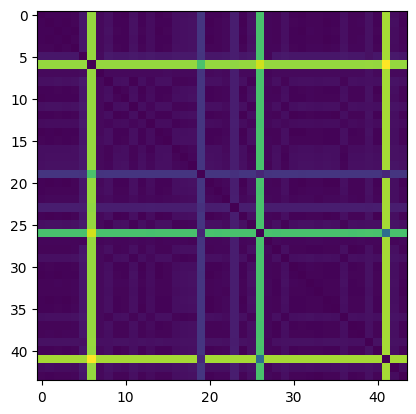

In [47]:
plt.imshow(matriciona)

In [49]:
from sklearn_extra.cluster import KMedoids



In [52]:
k_medoids = KMedoids(n_clusters=2, random_state=0, metric = 'precomputed').fit(matriciona) 


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1],
      dtype=int64)

In [53]:
k_medoids.labels_

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
      dtype=int64)

In [57]:
sse = []
for k in range(10):
    k_medoids = KMedoids(n_clusters=k+1, random_state=0, metric = 'precomputed').fit(matriciona) 
    sse.append(k_medoids.inertia_)
    print(k_medoids.inertia_)
    

79.8562068076802
75.26787695037419
74.43897741511681
73.85524903325242
73.28571421375783
72.86659459294225
72.65185019276674
72.41440740616959
72.18663623862348
72.00669536933806


Text(0.5, 1.0, 'SSE vs Number of Clusters')

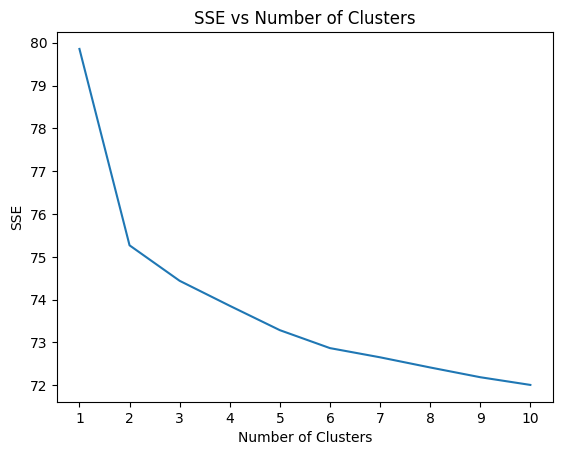

In [60]:
plt.plot( range(1,11), sse)
# set x ticks to be integers
plt.xticks(np.arange(1, 11, step=1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs Number of Clusters")


In [63]:
# refit with k=2

k_medoids = KMedoids(n_clusters=2, random_state=0, metric = 'precomputed').fit(matriciona)

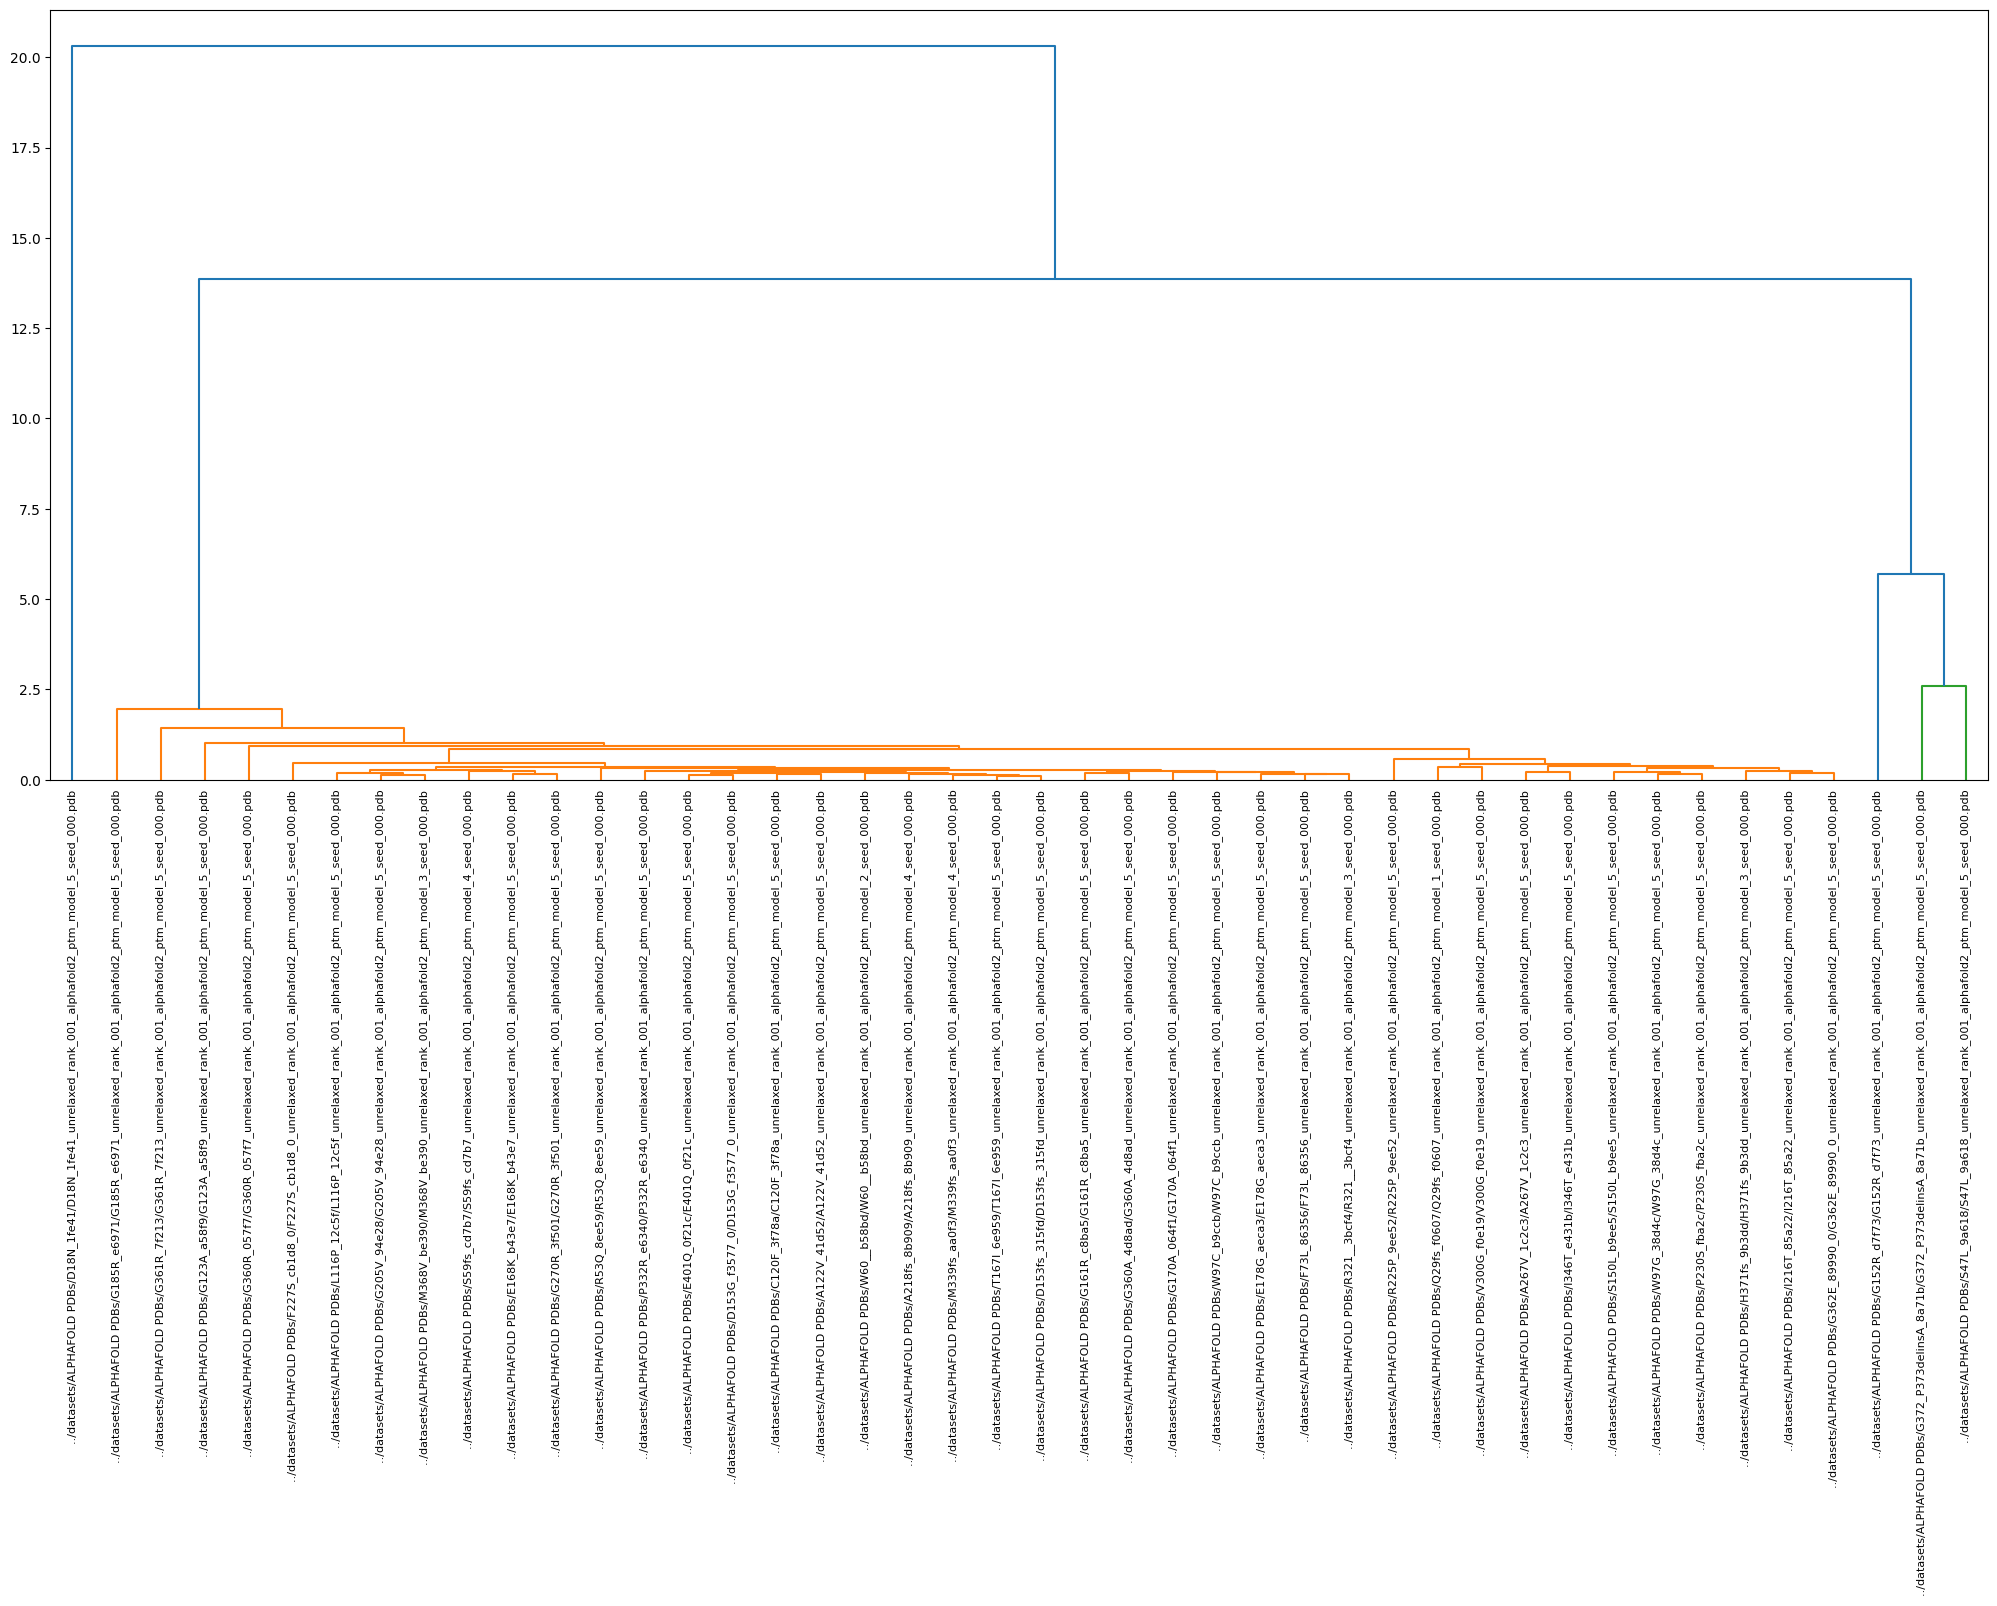

In [85]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='average', distance_threshold=None).fit(matriciona)

#dendrogram

from scipy.cluster.hierarchy import dendrogram, linkage

# condense the matrix

from scipy.spatial.distance import squareform
Z = linkage(squareform(matriciona), 'average')

plt.figure(figsize=(25, 10))
dendrogram(Z, color_threshold=3, labels=paths)
plt.show()

In [78]:
np.linalg.norm(matriciona- matriciona.T)
matriciona = (matriciona + matriciona.T) /2


In [83]:
for i in range(len(matriciona)):
    matriciona[i,i] = 0

In [82]:
len

<function len(obj, /)>